# Model Training
Train BGRU models for HK and US stock market, repectively

In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.metrics import Accuracy, MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Common variables and functions

In [97]:
MODEL_STRUCTURE_PATH = "./diagrams/model_structures"
PROCESSED_STOCKS_PATH = "./data/processed"
EVALUATE_STOCKS_PATH = "./data/processed/stocks_for_evaluate"

# stocks model checkpoint paths
HK_MODELS_CHECKPOINT_PATH = "./model/hk"
US_MODELS_CHECKPOINT_PATH = "./model/us"

hk_bgru_file_path = "{}/bgru.h5".format(HK_MODELS_CHECKPOINT_PATH)
us_bgru_file_path = "{}/bgru.h5".format(US_MODELS_CHECKPOINT_PATH)

TRAIN_EPOCHS = 100

def create_dir_if_not_exist(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname, exist_ok=True)

### Import datasets

In [98]:
# hk datasets
X_train_hk = np.load("{}/train_X_hk.npy".format(PROCESSED_STOCKS_PATH))
X_test_hk = np.load("{}/test_X_hk.npy".format(PROCESSED_STOCKS_PATH))
y_train_hk = np.load("{}/train_y_hk.npy".format(PROCESSED_STOCKS_PATH))
y_test_hk = np.load("{}/test_y_hk.npy".format(PROCESSED_STOCKS_PATH))

# us datasets
X_train_us = np.load("{}/train_X_us.npy".format(PROCESSED_STOCKS_PATH))
X_test_us = np.load("{}/test_X_us.npy".format(PROCESSED_STOCKS_PATH))
y_train_us = np.load("{}/train_y_us.npy".format(PROCESSED_STOCKS_PATH))
y_test_us = np.load("{}/test_y_us.npy".format(PROCESSED_STOCKS_PATH))

### Define models structure
##### BGRU models
###### Reference:
```
Salimath, S., Chatterjee, T., Mathai, T., Kamble, P., & Kolhekar, M. (2021, April). Prediction of Stock Price for Indian Stock Market: A Comparative Study Using LSTM and GRU. In International Conference on Advances in Computing and Data Sciences (pp. 292-302). Springer, Cham.
Lin, H., Chen, C., Huang, G., & Jafari, A. (2021). Stock price prediction using Generative Adversarial Networks. Journal of Computer Science, (17(3), 188–196. doi:10.3844/jcssp.2021.188.196
https://github.com/grudloff/stock_market_GAN
```

In [106]:
def make_bgru_model(input_dim, feature_cnt) -> tf.keras.models.Model:
    model = Sequential()

    # input layer
    model.add(
        Input(
            shape=(input_dim, feature_cnt)
        )
    )

    # first gru + dropout layer
    model.add(
        Bidirectional(
            GRU(
                units=128,
                return_sequences=True,
                input_shape=(input_dim, feature_cnt)
                )
        )
    )
    model.add(
        Dropout(rate=0.3)
    )

    # second gru + dropout layer
    model.add(
        Bidirectional(
            GRU(
                units=32,
                return_sequences=False, # important, convert array from 3d to 2d
                input_shape=(input_dim, feature_cnt)
                )
        )
    )
    model.add(
        Dropout(rate=0.3)
    )

    # output dense layer
    model.add(
        Dense(units = 1)
    )

    # compile model and use Adam optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="mse",
        metrics=[
            Accuracy(), MeanAbsoluteError(),
            RootMeanSquaredError(), MeanAbsolutePercentageError()
        ]
    )

    print(model.summary())
    return model

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_62 (Bidirectio (None, 30, 256)           106752    
_________________________________________________________________
dropout_60 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
bidirectional_63 (Bidirectio (None, 64)                55680     
_________________________________________________________________
dropout_61 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 162,497
Trainable params: 162,497
Non-trainable params: 0
_________________________________________________________________
None


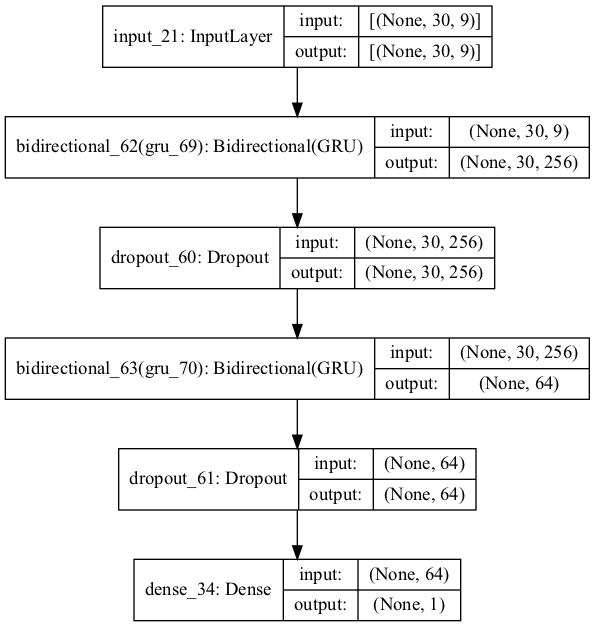

In [107]:
# plot model structure
create_dir_if_not_exist(MODEL_STRUCTURE_PATH)
plot_model(
    make_bgru_model(input_dim=X_train_hk.shape[1],
                    feature_cnt=X_train_hk.shape[2]
                    ),
    show_shapes=True,
    show_layer_names=True,
    to_file="{}/BGRU_structure.png".format(MODEL_STRUCTURE_PATH)
)


### Model training
##### Train BGRU model for Hong Kong Stocks

In [108]:
create_dir_if_not_exist(HK_MODELS_CHECKPOINT_PATH)
create_dir_if_not_exist(US_MODELS_CHECKPOINT_PATH)

In [109]:
# TODO: 1. Add model check point, 2. add where to save to model's file
hk_bgru_cp = ModelCheckpoint(
    filepath=hk_bgru_file_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
    mode="auto"
)

hk_bgru_es = EarlyStopping(
    monitor="val_loss",
    patience=5
)

hk_bgru_model = None
# check if we have previously trained model or not, ref: https://stackoverflow.com/a/56425146/9500852
if os.path.exists(hk_bgru_file_path):
    print("Found existing model")
    hk_bgru_model = load_model(hk_bgru_file_path)
    score = hk_bgru_model.evaluate()
else:
    print("No existing model is found")
    hk_bgru_model = make_bgru_model(
        input_dim=X_train_hk.shape[1],
        feature_cnt=X_train_hk.shape[2]
    )

# start fitting the model
hk_bgru_history = hk_bgru_model.fit(
    x=X_train_hk,
    y=y_train_hk,
    validation_data=(X_test_hk, y_test_hk),
    epochs=TRAIN_EPOCHS,
    callbacks=[
        hk_bgru_cp,
        hk_bgru_es
    ]
)

# save the model
hk_bgru_model.save(hk_bgru_file_path)

No existing model is found
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_64 (Bidirectio (None, 30, 256)           106752    
_________________________________________________________________
dropout_62 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
bidirectional_65 (Bidirectio (None, 64)                55680     
_________________________________________________________________
dropout_63 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 162,497
Trainable params: 162,497
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
 833/2982 [=======>......................] - ETA: 1:27 - loss: 0.0917

KeyboardInterrupt: 

In [103]:
y_train_hk.shape

(95403, 1)

##### Train BGRU model for United States stocks